# Overview

This notebook is adapted from CellOracle's GRN construction notebook (updated by 4/13/2022, Kenji Kamimoto).

# 0. Import libraries

In [ ]:
!pip install scanpy

In [ ]:
!pip install celloracle

In [ ]:
# 0. Import

import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

import celloracle as co
co.__version__

'0.14.0'

In [ ]:
# visualization settings
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

plt.rcParams['figure.figsize'] = [6, 4.5]
plt.rcParams["savefig.dpi"] = 300

## 0.2. Make a folder to save graph

In [ ]:
save_folder = "figures"
os.makedirs(save_folder, exist_ok=True)

# 1. Load data
## 1.1. Load processed gene expression data (anndata)



In [ ]:
# Load data
data = sc.read_h5ad("/content/Zebrafish_Neut_Mac_Harmony_Burn_Unwounded_Seurat_diet_cond-time_meta.h5ad")


# save counts to layers
adata.layers['counts'] = adata.raw.X.copy()
adata.layers['log1p'] = adata.X.copy()
adata

AnnData object with n_obs × n_vars = 19118 × 36351
    obs: 'orig.ident', 'abbreviation', 'Cond', 'Condition', 'Time', 'Timepoint', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.ribo', 'percent.hb', 'S.Score', 'G2M.Score', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.3', 'Identity', 'rev_Id', 'CellType', 'condition.cl', 'cond.time.cl'
    var: 'features'
    obsm: 'X_umap'
    layers: 'counts', 'log1p'

## 1.2 Preprocessing

In [ ]:
# Only consider genes with more than 1 count
sc.pp.filter_genes(adata, min_counts=1)

# Normalize gene expression matrix with total UMI count per cell
sc.pp.normalize_per_cell(adata, key_n_counts='nCount_RNA')

# Select top 3000 highly-variable genes
filter_result = sc.pp.filter_genes_dispersion(adata.X,
                                              flavor='cell_ranger',
                                              n_top_genes=3000,
                                              log=False)

# Subset the genes
adata = adata[:, filter_result.gene_subset]

# Renormalize after filtering
sc.pp.normalize_per_cell(adata)

In [ ]:
# scale data - unnecessary
#sc.pp.scale(adata)
adata

AnnData object with n_obs × n_vars = 19118 × 2999
    obs: 'orig.ident', 'abbreviation', 'Cond', 'Condition', 'Time', 'Timepoint', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.ribo', 'percent.hb', 'S.Score', 'G2M.Score', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.3', 'Identity', 'rev_Id', 'CellType', 'condition.cl', 'cond.time.cl', 'n_counts'
    var: 'features', 'n_counts'
    obsm: 'X_umap'
    layers: 'counts', 'log1p'

## 1.2. Load base-GRN data.


In [ ]:
# Load TF info which was made from mouse cell atlas dataset.
base_GRN = co.data.load_zebrafish_promoter_base_GRN()
# Check data
base_GRN.head()

# 2. Make Oracle object

In [ ]:
# Instantiate Oracle object
oracle = co.Oracle()

## 2.1. load gene expression data into oracle object.

In [ ]:
# Check data in anndata
print("Metadata columns :", list(adata.obs.columns))
print("Dimensional reduction: ", list(adata.obsm.keys()))

Metadata columns : ['orig.ident', 'abbreviation', 'Cond', 'Condition', 'Time', 'Timepoint', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.ribo', 'percent.hb', 'S.Score', 'G2M.Score', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.3', 'Identity', 'rev_Id', 'CellType', 'condition.cl', 'cond.time.cl', 'n_counts']
Dimensional reduction:  ['X_umap']


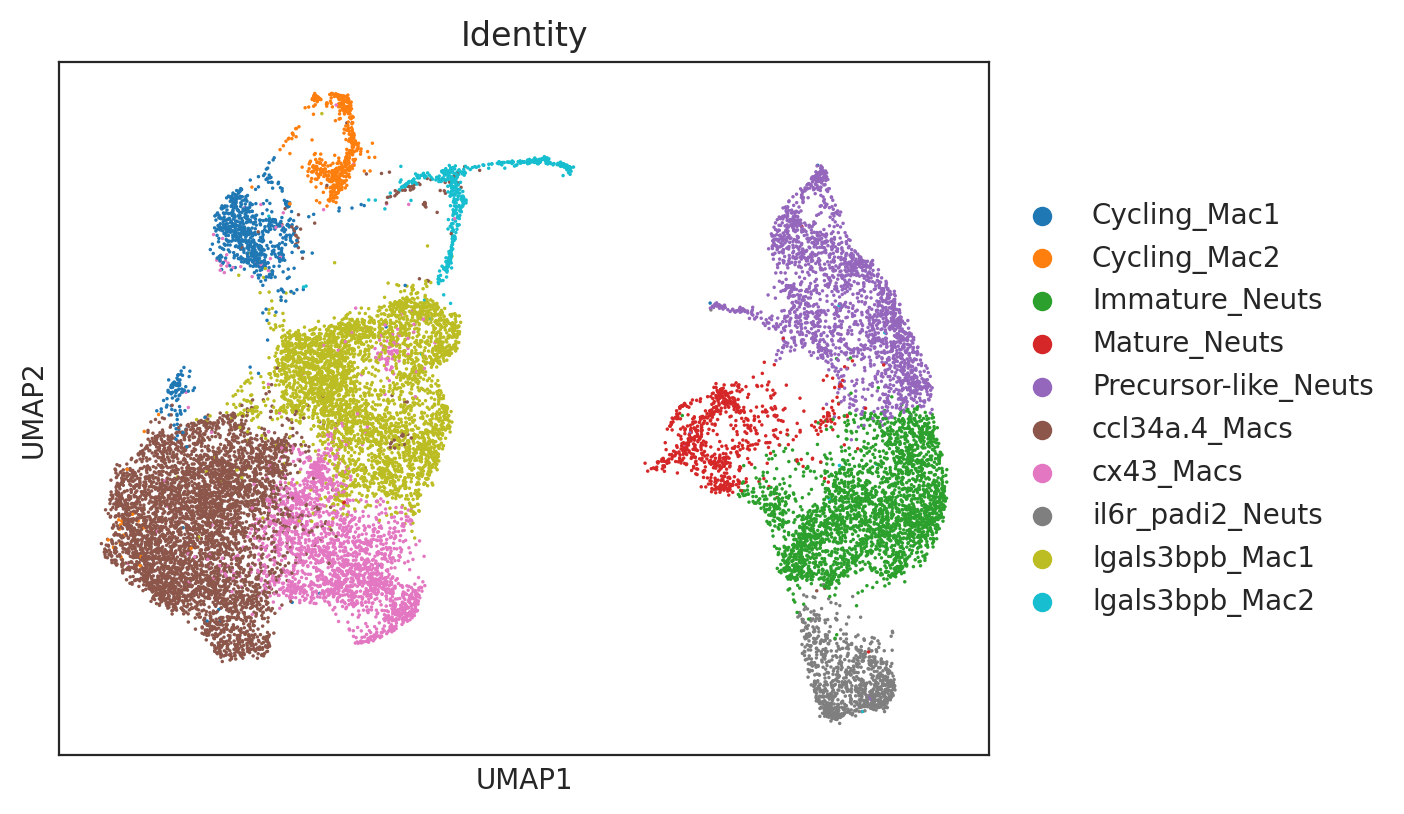

In [ ]:
# add counts data to adata
adata.X = adata.layers["counts"].copy()

# Instantiate Oracle object
sc.pl.umap(adata, color="Identity")
oracle.import_anndata_as_raw_count(adata=adata,
                                   cluster_column_name="Identity",
                                   embedding_name="X_umap")

## 2.2. Load base-GRN data into oracle object

In [ ]:
# You can load TF info dataframe with the following code.
oracle.import_TF_data(TF_info_matrix=base_GRN)

# 3. KNN imputation

## 3.1. PCA

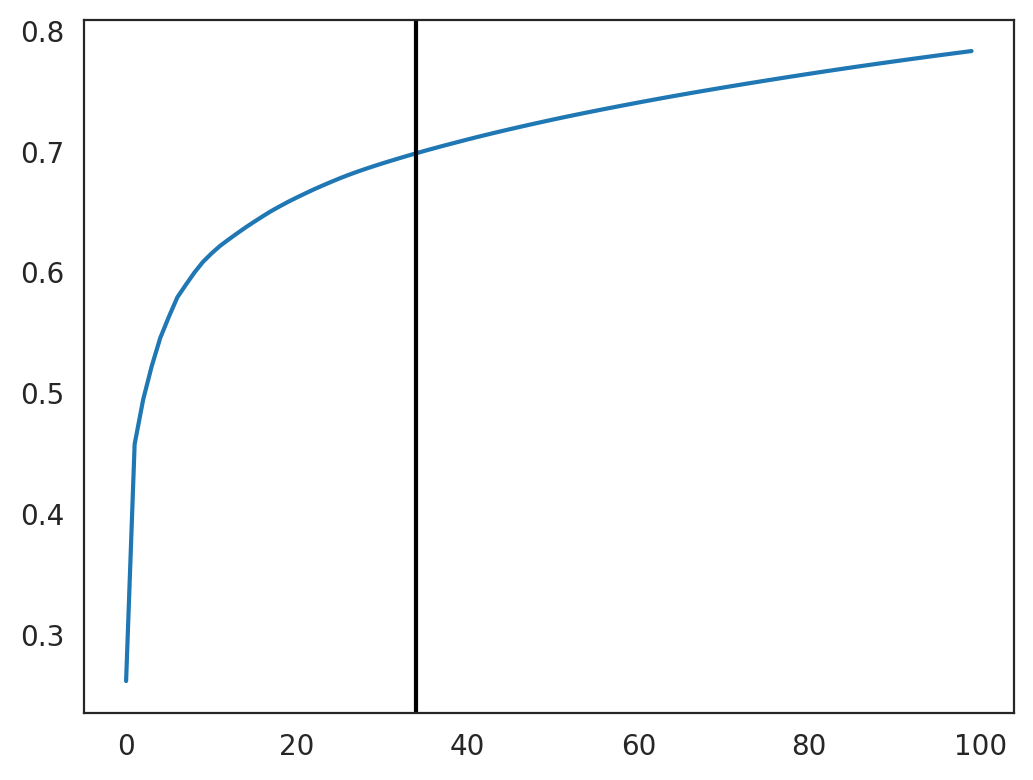

34


In [ ]:
# Perform PCA
oracle.perform_PCA()

# Select important PCs
plt.plot(np.cumsum(oracle.pca.explained_variance_ratio_)[:100])
n_comps = np.where(np.diff(np.diff(np.cumsum(oracle.pca.explained_variance_ratio_))>0.002))[0][0]
plt.axvline(n_comps, c="k")
plt.show()
print(n_comps)
n_comps = min(n_comps, 50)

## 3.2. KNN imputation

Estimate the optimal number of nearest neighbors for KNN imputation.

In [ ]:
n_cell = oracle.adata.shape[0]
print(f"cell number is :{n_cell}")

cell number is :19118


In [ ]:
k = int(0.025*n_cell)
print(f"Auto-selected k is :{k}")

Auto-selected k is :477


In [ ]:
oracle.knn_imputation(n_pca_dims=n_comps, k=k, balanced=True, b_sight=k*8,
                      b_maxl=k*4, n_jobs=4)

# 4. Save and Load.


In [ ]:
# Save oracle object.
# oracle.to_hdf5("Zebrafish_burn_data_burnt_only.celloracle.oracle")
oracle.to_hdf5("Zebrafish_burn_data_cond-time_split.celloracle.oracle")


In [ ]:
# Load file.
oracle = co.load_hdf5("/content/Zebrafish_burn_data_cond-time_split.celloracle.oracle")

# 5. GRN calculation



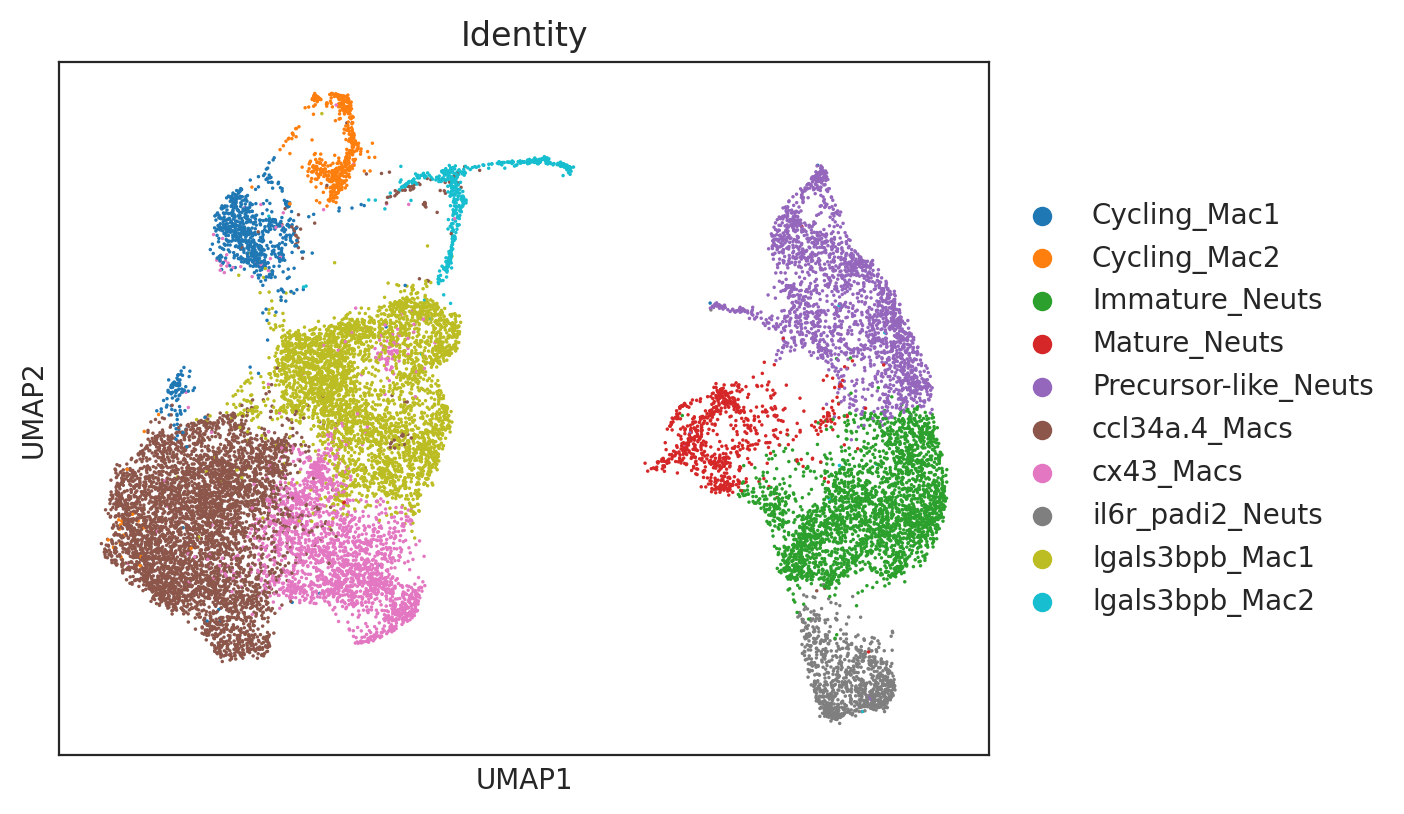

In [ ]:
# Check clustering data
sc.pl.umap(oracle.adata, color = "Identity")

## 5.1. Get GRNs

In [ ]:
%%time
# Calculate GRN for each population in "cond.time.cl" clustering unit.

links = oracle.get_links(cluster_name_for_GRN_unit="cond.time.cl", alpha=10,
                         verbose_level=10)

In [ ]:
# Save Links object.
links.to_hdf5(file_path="Zebrafish_burn_data_cond-time_split.celloracle.links")

In [ ]:
%%time
# Calculate GRN for each population in "condition.cl" clustering unit

links2 = oracle.get_links(cluster_name_for_GRN_unit="condition.cl", alpha=10,
                         verbose_level=10)

In [ ]:
# Save Links object.
links2.to_hdf5(file_path="Zebrafish_burn_data_cond_split.celloracle.links")

# 6. Network preprocessing

## 6.1. Filter network edges


In [ ]:
links.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)

In [ ]:
links2.filter_links(p=0.001, weight="coef_abs", threshold_number=2000)

## 6.2. Degree distribution

In [ ]:
plt.rcParams["figure.figsize"] = [9, 4.5]

In [ ]:
links.plot_degree_distributions(plot_model=True,
                                               save=f"{save_folder}/degree_distribution/",
                                               )

In [ ]:
plt.rcParams["figure.figsize"] = [6, 4.5]

## 6.3. Calculate netowrk score


In [ ]:
# Calculate network scores.
links.get_network_score()

In [ ]:
# Calculate network scores.
links2.get_network_score()

The score is stored as a attribute `merged_score`.

In [ ]:
links.merged_score.head()

## 6.4. Save

Save processed GRNs. We will use this file during the in in silico TF perturbation analysis.

In [ ]:
# Save Links object.
links.to_hdf5(file_path="Zebrafish_burn_data_cond-time_split_filtered_scored.celloracle.links")

In [ ]:
# Save Links object.
links2.to_hdf5(file_path="Zebrafish_burn_data_cond_split_filtered_scored.celloracle.links")

In [ ]:
# load files when resuming
links = co.load_hdf5(file_path="Zebrafish_burn_data_cond-time_split_filtered_scored.celloracle.links")

# 7. Network analysis; Network score for each gene

## 7.1. Network score in each cluster


Visualize genes with high network centrality.


In [ ]:
# Check cluster name
links.cluster

In [ ]:
os.makedirs("genes", exist_ok=True)

In [ ]:
# Check and save ALL genes
merged_scores = links.merged_score
for clust in links.cluster:
  paths = ["genes/",clust, "_all_genes.csv"]
  filepath = "".join(paths)
  scores = merged_scores.loc[merged_scores['cluster'] == clust]
  scoreshead = scores.sort_values('degree_centrality_all', ascending=False)
  scoreshead.to_csv(filepath)


In [ ]:
# Check and save ALL genes
merged_scores = links2.merged_score
for clust in links2.cluster:
  paths = ["genes/",clust, "_all_genes.csv"]
  filepath = "".join(paths)
  scores = merged_scores.loc[merged_scores['cluster'] == clust]
  scoreshead = scores.sort_values('degree_centrality_all', ascending=False)
  scoreshead.to_csv(filepath)

In [ ]:
#
!zip -r /content/burn_uninjured_top_genes.zip /content/genes

In [ ]:
# Visualize top n-th genes with high scores.
links.plot_scores_as_rank(cluster="Mature_Neuts", n_gene=30, save=f"{save_folder}/ranked_score")

## 7.2. Network score comparison between two clusters


By comparing network scores between two clusters, we can analyze differences in GRN structure.

In [ ]:
# Compare GRN score between two clusters
links.plot_score_comparison_2D(value="degree_centrality_all",
                               cluster1="", cluster2="",
                               percentile=97,
                               save=f"{save_folder}/score_comparison")